# Decision Trees

## 1. Problem Statement

* Dataset: https://github.com/gastonstat/CreditScoring"

The raw dataset is in the file **"CreditScoring.csv"** which contains 4455 rows and 14 columns:

<table>
<tbody>
<tr><td><b>1  Status</b></td> <td>credit status</td></tr>
<tr><td><b>2  Seniority</b></td> <td>job seniority (years)</td></tr>
<tr><td><b>3  Home</b></td> <td>type of home ownership</td></tr>
<tr><td><b>4  Time</b></td> <td>time of requested loan</td></tr>
<tr><td><b>5  Age</b></td> <td>client's age </td></tr>
<tr><td><b>6  Marital</b></td> <td>marital status </td></tr>
<tr><td><b>7  Records</b></td> <td>existance of records</td></tr>
<tr><td><b>8  Job</b></td> <td>type of job</td></tr>
<tr><td><b>9  Expenses</b></td> <td> amount of expenses</td></tr>
<tr><td><b>10 Income</b></td> <td> amount of income</td></tr>
<tr><td><b>11 Assets</b></td> <td> amount of assets</td></tr>
<tr><td><b>12 Debt</b></td> <td> amount of debt</td></tr>
<tr><td><b>13 Amount</b></td> <td> amount requested of loan</td></tr>
<tr><td><b>14 Price</b></td> <td> price of good</td></tr>
</tbody>
</table>

In this session we'll learn about decision trees and ensemble learning algorithms. The questions that we try to address this week are, "What are decision trees? How are they different from ensemble algorithms? How can we implement and fine-tune these models to make binary classification predictions?"

To be specific, we'll use credit scoring data to build a model that predicts whether a bank should lend loan to a client or not. The bank takes these decisions based on the historical record.

In the credit scoring classification problem,

- if the model returns 0, this means, the client is very likely to payback the loan and the bank will approve the loan.
- if the model returns 1, then the client is considered as a defaulter and the bank may not approval the loan.

In [4]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### 2. Data Preparation

We'll perform the following steps to prepare the dataset for training:

1. Create a train/plit
2. Identify input and target columns
3. Identify numeric and categorical columns
4. Impute (fill) missing numeric values
5. Scale numeric values to the $(0, 1)$ range
6. Encode categorical columns to one-hot vectors

In [6]:
df = pd.read_csv('CreditScoring.csv')
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [7]:
df.columns = df.columns.str.lower()

In [8]:
df.status.value_counts()

status
1    3200
2    1254
0       1
Name: count, dtype: int64

In [9]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk' # unknown
}

df.status = df.status.map(status_values)

In [10]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)


In [11]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [12]:
df.describe().T.round()

,count,mean,std,min,25%,50%,75%,max
seniority,4455.0,8.0,8.0,0.0,2.0,5.0,12.0,48.0
time,4455.0,46.0,15.0,6.0,36.0,48.0,60.0,72.0
age,4455.0,37.0,11.0,18.0,28.0,36.0,45.0,68.0
expenses,4455.0,56.0,20.0,35.0,35.0,51.0,72.0,180.0
income,4455.0,763317.0,8703625.0,0.0,80.0,120.0,166.0,99999999.0
assets,4455.0,1060341.0,10217569.0,0.0,0.0,3500.0,6000.0,99999999.0
debt,4455.0,404382.0,6344253.0,0.0,0.0,0.0,0.0,99999999.0
amount,4455.0,1039.0,475.0,100.0,700.0,1000.0,1300.0,5000.0
price,4455.0,1463.0,628.0,105.0,1118.0,1400.0,1692.0,11140.0


In [13]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [14]:
df.describe().T.round()

,count,mean,std,min,25%,50%,75%,max
seniority,4455.0,8.0,8.0,0.0,2.0,5.0,12.0,48.0
time,4455.0,46.0,15.0,6.0,36.0,48.0,60.0,72.0
age,4455.0,37.0,11.0,18.0,28.0,36.0,45.0,68.0
expenses,4455.0,56.0,20.0,35.0,35.0,51.0,72.0,180.0
income,4421.0,131.0,86.0,0.0,80.0,120.0,165.0,959.0
assets,4408.0,5403.0,11573.0,0.0,0.0,3000.0,6000.0,300000.0
debt,4437.0,343.0,1246.0,0.0,0.0,0.0,0.0,30000.0
amount,4455.0,1039.0,475.0,100.0,700.0,1000.0,1300.0,5000.0
price,4455.0,1463.0,628.0,105.0,1118.0,1400.0,1692.0,11140.0


In [15]:
df = df[df.status != 'unk'].reset_index(drop=True)

In [16]:
df.status = (df.status == 'default').astype('int').values

In [17]:
df[df.home=='unk']

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
29,1,0,unk,48,37,single,no,unk,35,NaN,NaN,NaN,1500,1850
239,0,3,unk,24,42,single,no,fixed,35,337.0,NaN,NaN,1300,1624
1059,0,6,unk,12,25,single,no,fixed,35,69.0,NaN,NaN,500,1275
1676,1,4,unk,48,47,married,yes,freelance,45,NaN,NaN,NaN,1350,2172
2388,1,0,unk,48,23,married,no,partime,45,26.0,NaN,NaN,1350,1562
2995,1,10,unk,18,47,married,yes,freelance,45,NaN,NaN,NaN,700,1428


### Input and Target Columns

Let's identify the input and target columns.

In [19]:
X = df.drop('status', axis=1)
y = df['status']

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
train_inputs, test_inputs, train_target, test_target = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
len(train_inputs), len(test_inputs)

(3563, 891)

Let's also identify the numeric and categorical columns.

In [24]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [25]:
print(numeric_cols)

['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price']


In [26]:
print(categorical_cols)

['home', 'marital', 'records', 'job']


### Imputing missing numeric values

In [28]:
from sklearn.impute import SimpleImputer

In [29]:
imputer = SimpleImputer(strategy = 'mean').fit(df[numeric_cols])

In [30]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])

test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

In [31]:
test_inputs[numeric_cols].isna().sum()

seniority    0
time         0
age          0
expenses     0
income       0
assets       0
debt         0
amount       0
price        0
dtype: int64

In [32]:
from sklearn.preprocessing import StandardScaler

### Scaling Numeric Features

In [34]:
scaler = StandardScaler()

In [35]:
train_inputs[numeric_cols] = scaler.fit_transform(train_inputs[numeric_cols])

test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [36]:
train_inputs.describe().loc[['min', 'max']]

,seniority,time,age,expenses,income,assets,debt,amount,price
min,-0.979211,-2.741132,-1.732385,-1.047395,-1.496701,-0.455838,-0.277255,-1.944654,-2.085752
max,4.881455,1.743285,2.784421,6.296511,9.419314,24.134149,24.388363,8.171137,14.792686


### Encoding Categorical Data

In [38]:
from sklearn.preprocessing import OneHotEncoder

In [39]:
train_inputs[categorical_cols] = train_inputs[categorical_cols].fillna('Unknown')

test_inputs[categorical_cols] = test_inputs[categorical_cols].fillna('Unknown')

In [40]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(df[categorical_cols])

In [41]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [42]:
encoded_cols

['home_ignore',
 'home_other',
 'home_owner',
 'home_parents',
 'home_private',
 'home_rent',
 'home_unk',
 'marital_divorced',
 'marital_married',
 'marital_separated',
 'marital_single',
 'marital_unk',
 'marital_widow',
 'records_no',
 'records_yes',
 'job_fixed',
 'job_freelance',
 'job_others',
 'job_partime',
 'job_unk']

In [43]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])

test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

In [44]:
X_train = train_inputs[numeric_cols + encoded_cols]

X_test = test_inputs[numeric_cols + encoded_cols]

## Training and Visualizing Decision Trees

A decision tree in general parlance represents a hierarchical series of binary decisions:

<img src="https://i.imgur.com/qSH4lqz.png" width="480">

A decision tree in machine learning works in exactly the same way, and except that we let the computer figure out the optimal structure & hierarchy of decisions, instead of coming up with criteria manually.

In [46]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

xi = train_inputs.iloc[0].to_dict()
xi
assess_risk(xi)

'default'

In [47]:
from sklearn.tree import DecisionTreeClassifier

In [48]:
model = DecisionTreeClassifier(random_state=42)

In [49]:
%%time
model.fit(X_train, train_target)

CPU times: total: 0 ns
Wall time: 43.2 ms


DecisionTreeClassifier(random_state=42)

In [50]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [51]:
train_preds = model.predict(X_train)

In [52]:
train_preds


array([0, 0, 0, ..., 0, 1, 0])

In [53]:
pd.value_counts(train_preds)


C:\Users\User\AppData\Local\Temp\ipykernel_16208\1515116987.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(train_preds)


0    2586
1     977
Name: count, dtype: int64

In [54]:
train_probs = model.predict_proba(X_train)

In [55]:
train_probs


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [56]:
accuracy_score(train_target, train_preds)

0.9997193376368229

In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [58]:
y_pred = model.predict_proba(X_train)[:, 1]
auc = roc_auc_score(train_target, y_pred)
print('train: ', auc)


y_pred = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(test_target, y_pred)
print('test: ', auc)

train:  0.9999998022253602
test:  0.6514404383174266


In [59]:
model.tree_.max_depth

20

It appears that the model has learned the training examples perfect, and doesn't generalize well to previously unseen examples. This phenomenon is called "overfitting", and reducing overfitting is one of the most important parts of any machine learning project.

**Overfitting** is a common problem in machine learning and statistical modeling where a model learns the training data to an extent that it captures noise or random fluctuations in the data rather than the underlying patterns. In other words, an overfit model fits the training data too closely and fails to generalize well to unseen or new data. This can result in poor model performance and accuracy when applied in real-world scenarios. Overfitting can occur in various types of machine learning models, including decision trees, neural networks, support vector machines, and more.

In [62]:
from sklearn.tree import plot_tree, export_text

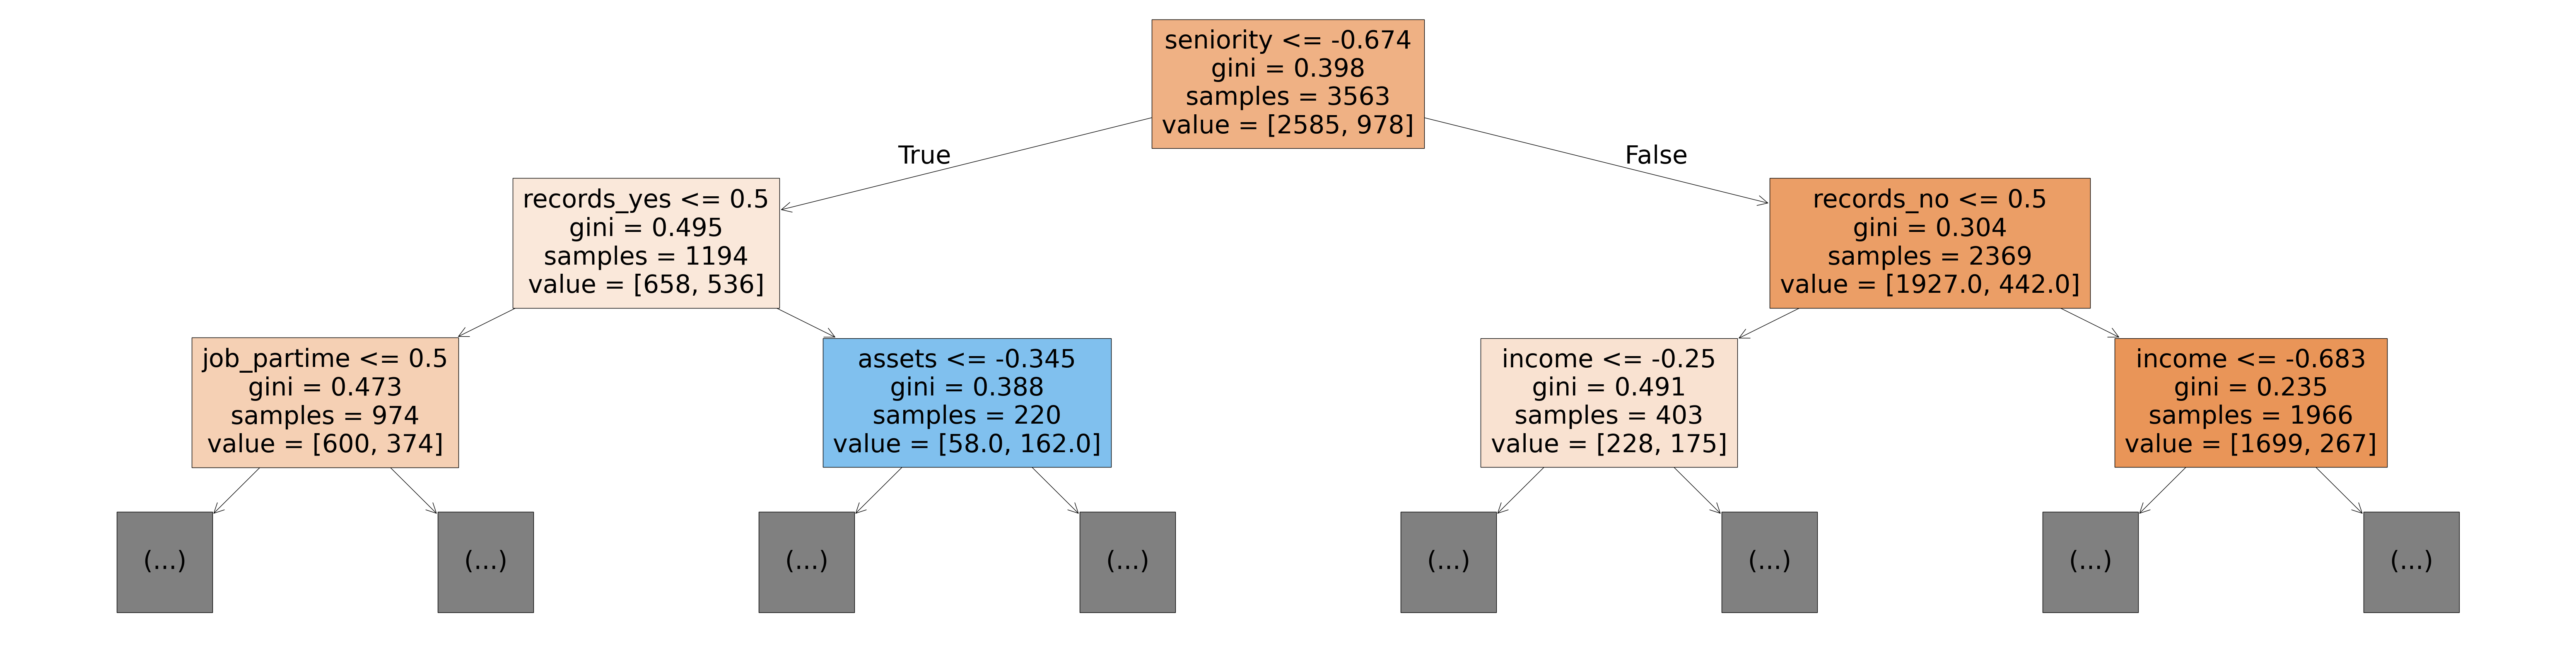

In [63]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns.tolist(), max_depth=2, filled=True);

Can you see how the model classifies a given input as a series of decisions? The tree is truncated here, but following any path from the root node down to a leaf will result in "Yes" or "No". Do you see how a decision tree differs from a logistic regression model?


**How a Decision Tree is Created**

Note the `gini` value in each box. This is the loss function used by the decision tree to decide which column should be used for splitting the data, and at what point the column should be split. A lower Gini index indicates a better split. A perfect split (only one class on each side) has a Gini index of 0. 

For a mathematical discussion of the Gini Index, watch this video: https://www.youtube.com/watch?v=-W0DnxQK1Eo . It has the following formula:

<img src="https://i.imgur.com/CSC0gAo.png" width="240">

Conceptually speaking, while training the models evaluates all possible splits across all possible columns and picks the best one. Then, it recursively performs an optimal split for the two portions. In practice, however, it's very inefficient to check all possible splits, so the model uses a heuristic (predefined strategy) combined with some randomization.


Let's check the depth of the tree that was created.

In [65]:
model.tree_.max_depth

20

In [66]:
y_pred = model.predict_proba(X_train)[:, 1]
auc = roc_auc_score(train_target, y_pred)
print('train: ', auc)


y_pred = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(test_target, y_pred)
print('test: ', auc)

train:  0.9999998022253602
test:  0.6514404383174266


In [67]:
tree_text = export_text(model, max_depth=2, feature_names=list(X_train.columns))
print(tree_text[:5000])

|--- seniority <= -0.67
|   |--- records_yes <= 0.50
|   |   |--- job_partime <= 0.50
|   |   |   |--- truncated branch of depth 18
|   |   |--- job_partime >  0.50
|   |   |   |--- truncated branch of depth 18
|   |--- records_yes >  0.50
|   |   |--- assets <= -0.35
|   |   |   |--- truncated branch of depth 9
|   |   |--- assets >  -0.35
|   |   |   |--- truncated branch of depth 11
|--- seniority >  -0.67
|   |--- records_no <= 0.50
|   |   |--- income <= -0.25
|   |   |   |--- truncated branch of depth 14
|   |   |--- income >  -0.25
|   |   |   |--- truncated branch of depth 18
|   |--- records_no >  0.50
|   |   |--- income <= -0.68
|   |   |   |--- truncated branch of depth 15
|   |   |--- income >  -0.68
|   |   |   |--- truncated branch of depth 17



The situation where training accuracy is 100% while validation accuracy is lower typically indicates overfitting. Overfitting occurs when a model learns the training data too well, capturing noise and details that don't generalize to new data. Possible reasons include memorizing the training set, having a too complex model, lack of regularization, and limited data. To address overfitting, consider using regularization techniques, cross-validation, feature engineering, data augmentation, and finding a balance between model complexity and generalization. Monitoring both training and validation metrics helps identify and address overfitting during model development.

### Feature Importance

Based on the gini index computations, a decision tree assigns an "importance" value to each feature. These values can be used to interpret the results given by a decision tree.

In [70]:
model.feature_importances_

array([0.12617494, 0.05008573, 0.09729445, 0.06399113, 0.16103214,
       0.06691558, 0.02924274, 0.10548945, 0.11534907, 0.00176093,
       0.00258554, 0.015341  , 0.00665316, 0.00848363, 0.01208175,
       0.00112804, 0.0024641 , 0.00392034, 0.00401733, 0.00535592,
       0.        , 0.00311045, 0.04200915, 0.03142842, 0.00987391,
       0.00824706, 0.00036897, 0.02559507, 0.        ])

In [71]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)


importance_df.head(10)

,feature,importance
4,income,0.161032
0,seniority,0.126175
8,price,0.115349
7,amount,0.105489
2,age,0.097294
5,assets,0.066916
3,expenses,0.063991
1,time,0.050086
22,records_no,0.042009
23,records_yes,0.031428


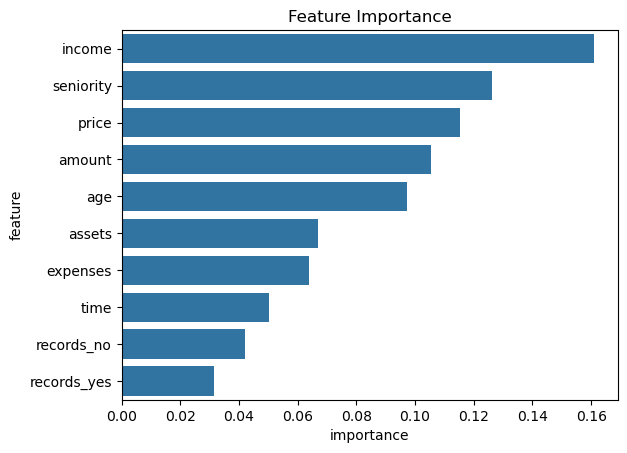

In [72]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

## Hyperparameter Tuning and Overfitting

As we saw in the previous section, our decision tree classifier memorized all training examples, leading to a 100% training accuracy, while the validation accuracy was only marginally better than a dumb baseline model. This phenomenon is called overfitting, and in this section, we'll look at some strategies for reducing overfitting. The process of reducing overfitting is known as **`Regularization`**


The `DecisionTreeClassifier` accepts several arguments, some of which can be modified to reduce overfitting.

In [74]:
?DecisionTreeClassifier

Init signature:
DecisionTreeClassifier(
    *,
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,
    ccp_alpha=0.0,
    monotonic_cst=None,
)
Docstring:     
A decision tree classifier.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : {"gini", "entropy", "log_loss"}, default="gini"
    The function to measure the quality of a split. Supported criteria are
    "gini" for the Gini impurity and "log_loss" and "entropy" both for the
    Shannon information gain, see :ref:`tree_mathematical_formulation`.

splitter : {"best", "random"}, default="best"
    The strategy used to choose the split at each node. Supported
    strategies are "best" to choose the best split and "random" to choose
    the best random split.

max_depth : int, default=None

These arguments are called hyperparameters because they must be configured manually (as opposed to the parameters within the model which are _learned_ from the data. We'll explore a couple of hyperparameters:

- `max_depth`
- `max_leaf_nodes`

### `max_depth`

By reducing the maximum depth of the decision tree, we can prevent the tree from memorizing all training examples, which may lead to better generalization

In [77]:
model = DecisionTreeClassifier(max_depth=4)
model.fit(X_train, train_target)

DecisionTreeClassifier(max_depth=4)

In [78]:
model = DecisionTreeClassifier(max_depth=4)
model.fit(X_train, train_target)

y_pred = model.predict_proba(X_train)[:, 1]
auc = roc_auc_score(train_target, y_pred)
print('train: ', auc)


y_pred = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(test_target, y_pred)
print('test: ', auc)

train:  0.7975129839050997
test:  0.7668846471073406


Great, while the training accuracy of the model has gone down, the validation accuracy of the model has increased significantly.

In [80]:
model.classes_

array([0, 1])

In [81]:
# Assuming model.classes_ is an array of integers
model_classes = model.classes_

# Convert the integer classes to strings
model_classes_str = [str(c) for c in model_classes]

print(model_classes_str)

['0', '1']


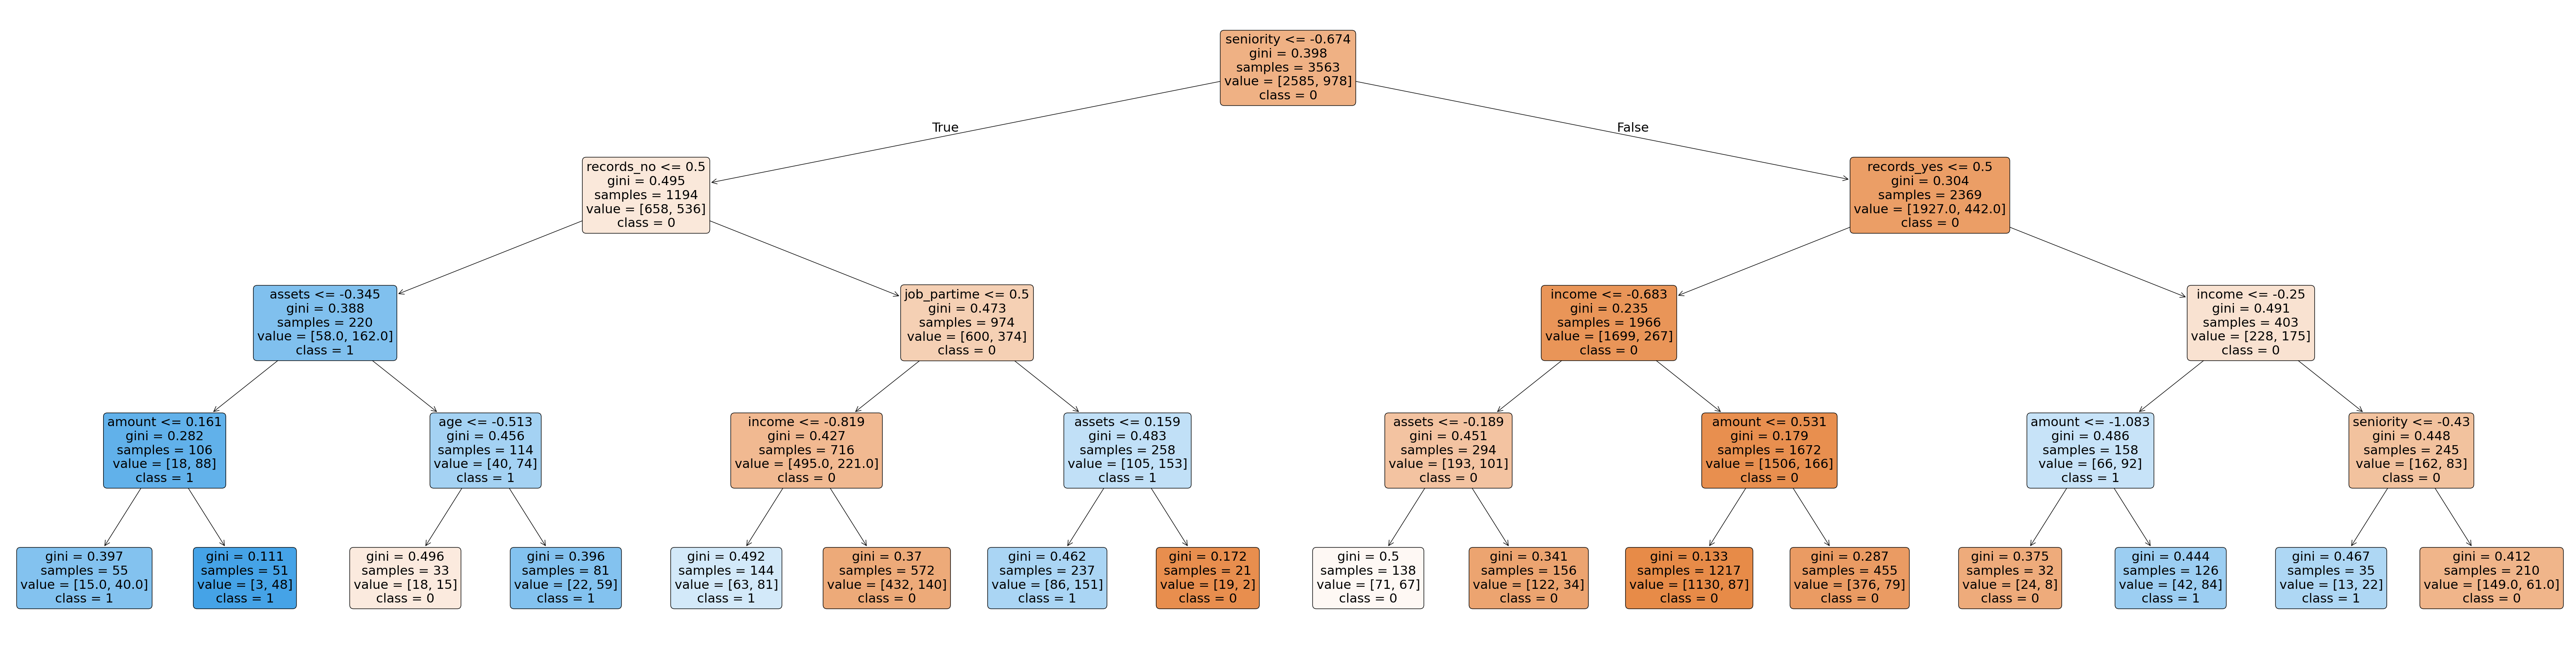

In [82]:
plt.figure(figsize=(80, 20))
plot_tree(model, feature_names=X_train.columns.tolist(), filled=True, rounded=True, class_names=model_classes_str);

In [83]:
print(export_text(model, feature_names=list(X_train.columns)))

|--- seniority <= -0.67
|   |--- records_no <= 0.50
|   |   |--- assets <= -0.35
|   |   |   |--- amount <= 0.16
|   |   |   |   |--- class: 1
|   |   |   |--- amount >  0.16
|   |   |   |   |--- class: 1
|   |   |--- assets >  -0.35
|   |   |   |--- age <= -0.51
|   |   |   |   |--- class: 0
|   |   |   |--- age >  -0.51
|   |   |   |   |--- class: 1
|   |--- records_no >  0.50
|   |   |--- job_partime <= 0.50
|   |   |   |--- income <= -0.82
|   |   |   |   |--- class: 1
|   |   |   |--- income >  -0.82
|   |   |   |   |--- class: 0
|   |   |--- job_partime >  0.50
|   |   |   |--- assets <= 0.16
|   |   |   |   |--- class: 1
|   |   |   |--- assets >  0.16
|   |   |   |   |--- class: 0
|--- seniority >  -0.67
|   |--- records_yes <= 0.50
|   |   |--- income <= -0.68
|   |   |   |--- assets <= -0.19
|   |   |   |   |--- class: 0
|   |   |   |--- assets >  -0.19
|   |   |   |   |--- class: 0
|   |   |--- income >  -0.68
|   |   |   |--- amount <= 0.53
|   |   |   |   |--- class: 0
|  

In [84]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

# Create an empty list to store the results
results_list = []

for depth in range(1, 21): 
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(X_train, train_target)
    
    train_error = 1 - model.score(X_train, train_target)
    val_error   = 1 - model.score(X_test, test_target)
    
    # Append the results as a dictionary to the list
    results_list.append({'Max Depth': depth, 'Training Error': train_error, 'Validation Error': val_error})

# Convert the list of results to a DataFrame in one step
results_df = pd.DataFrame(results_list)

# Display the DataFrame
print(results_df)


    Max Depth  Training Error  Validation Error
0           1        0.274488          0.309764
1           2        0.245299          0.268238
2           3        0.224530          0.252525
3           4        0.206848          0.240180
4           5        0.191692          0.228956
5           6        0.173449          0.236813
6           7        0.160820          0.240180
7           8        0.140893          0.249158
8           9        0.114791          0.248036
9          10        0.089812          0.268238
10         11        0.067640          0.261504
11         12        0.049677          0.269360
12         13        0.036486          0.281706
13         14        0.024979          0.279461
14         15        0.017401          0.280584
15         16        0.011788          0.279461
16         17        0.007017          0.286195
17         18        0.004210          0.277217
18         19        0.001403          0.294052
19         20        0.000281          0

This is a common pattern you'll see with all machine learning algorithms:

<img src="https://i.imgur.com/EJCrSZw.png" width="480">




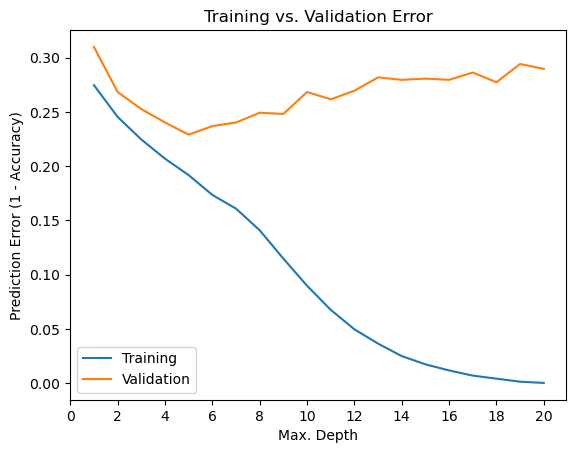

In [86]:
plt.figure()
plt.plot(results_df['Max Depth'], results_df['Training Error'])
plt.plot(results_df['Max Depth'], results_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

You'll often need to tune hyperparameters carefully to find the optimal fit. In the above case, it appears that a maximum depth of 7 results in the lowest validation error.

In [88]:
model = DecisionTreeClassifier(max_depth=4)
model.fit(X_train, train_target)

y_pred = model.predict_proba(X_train)[:, 1]
auc = roc_auc_score(train_target, y_pred)
print('train: ', auc)


y_pred = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(test_target, y_pred)
print('test: ', auc)

train:  0.7975129839050997
test:  0.7668846471073406


In [89]:
scores = []

for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, train_target)

        y_pred = dt.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(test_target, y_pred)
        
        scores.append((depth, s, auc))

In [90]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [91]:
df_scores

,max_depth,min_samples_leaf,auc
0,4,1,0.766885
1,4,5,0.766885
2,4,10,0.766885
3,4,15,0.766885
4,4,20,0.766885
5,4,500,0.720802
6,4,100,0.769418
7,4,200,0.766019
8,5,1,0.780358
9,5,5,0.780476


In [92]:
df_scores.sort_values(by='auc', ascending=False)

,max_depth,min_samples_leaf,auc
17,6,5,0.798439
22,6,100,0.795914
19,6,15,0.793396
14,5,100,0.791555
18,6,10,0.790706
20,6,20,0.787068
23,6,200,0.786532
15,5,200,0.782833
9,5,5,0.780476
8,5,1,0.780358


In [93]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.767  0.780  0.779
5                 0.767  0.780  0.798
10                0.767  0.779  0.791
15                0.767  0.780  0.793
20                0.767  0.776  0.787
100               0.769  0.792  0.796
200               0.766  0.783  0.787
500               0.721  0.721  0.721

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

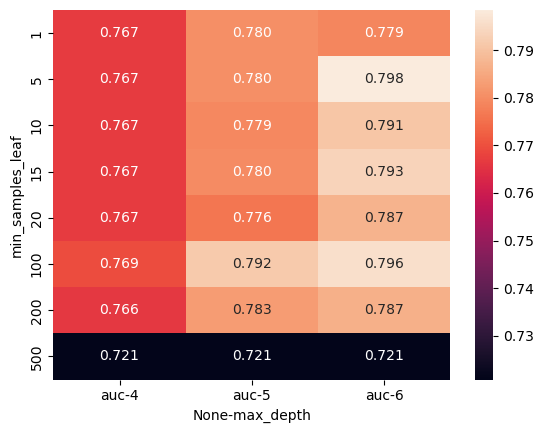

In [94]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

## Training a Random Forest

While tuning the hyperparameters of a single decision tree may lead to some improvements, a much more effective strategy is to combine the results of several decision trees trained with slightly different parameters. This is called a random forest model. 

The key idea here is that each decision tree in the forest will make different kinds of errors, and upon averaging, many of their errors will cancel out. This idea is also commonly known as the "wisdom of the crowd":

A random forest works by averaging/combining the results of several decision trees:

<img src="https://1.bp.blogspot.com/-Ax59WK4DE8w/YK6o9bt_9jI/AAAAAAAAEQA/9KbBf9cdL6kOFkJnU39aUn4m8ydThPenwCLcBGAsYHQ/s0/Random%2BForest%2B03.gif" width="640">


We'll use the `RandomForestClassifier` class from `sklearn.ensemble`.

In [197]:
from sklearn.ensemble import RandomForestClassifier

In [199]:
model = RandomForestClassifier(n_jobs=-1, random_state=42)

`n_jobs` allows the random forest to use mutiple parallel workers to train decision trees, and `random_state=42` ensures that the we get the same results for each execution.

In [204]:
%%time
model.fit(X_train, train_target)

CPU times: total: 359 ms
Wall time: 301 ms


RandomForestClassifier(n_jobs=-1, random_state=42)

In [206]:
model.score(X_train, train_target)

0.9997193376368229

In [208]:
y_pred = model.predict_proba(X_train)[:, 1]
auc = roc_auc_score(train_target, y_pred)
print('train: ', auc)


y_pred = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(test_target, y_pred)
print('test: ', auc)

train:  0.9999998022253602
test:  0.8378961941793331


Once again, the training accuracy is almost 100%, but this time the validation accuracy is much better. In fact, it is better than the best single decision tree we had trained so far. Do you see the power of random forests?

This general technique of combining the results of many models is called "ensembling", it works because most errors of individual models cancel out on averaging. Here's what it looks like visually:

<img src="https://i.imgur.com/qJo8D8b.png" width="640">


We can also look at the probabilities for the predictions. The probability of a class is simply the fraction of trees which that predicted the given class.

In [211]:
train_probs = model.predict_proba(X_train)
train_probs

array([[0.91, 0.09],
       [0.98, 0.02],
       [0.94, 0.06],
       ...,
       [1.  , 0.  ],
       [0.18, 0.82],
       [0.98, 0.02]])

In [213]:
model.estimators_[0]

DecisionTreeClassifier(max_features='sqrt', random_state=1608637542)

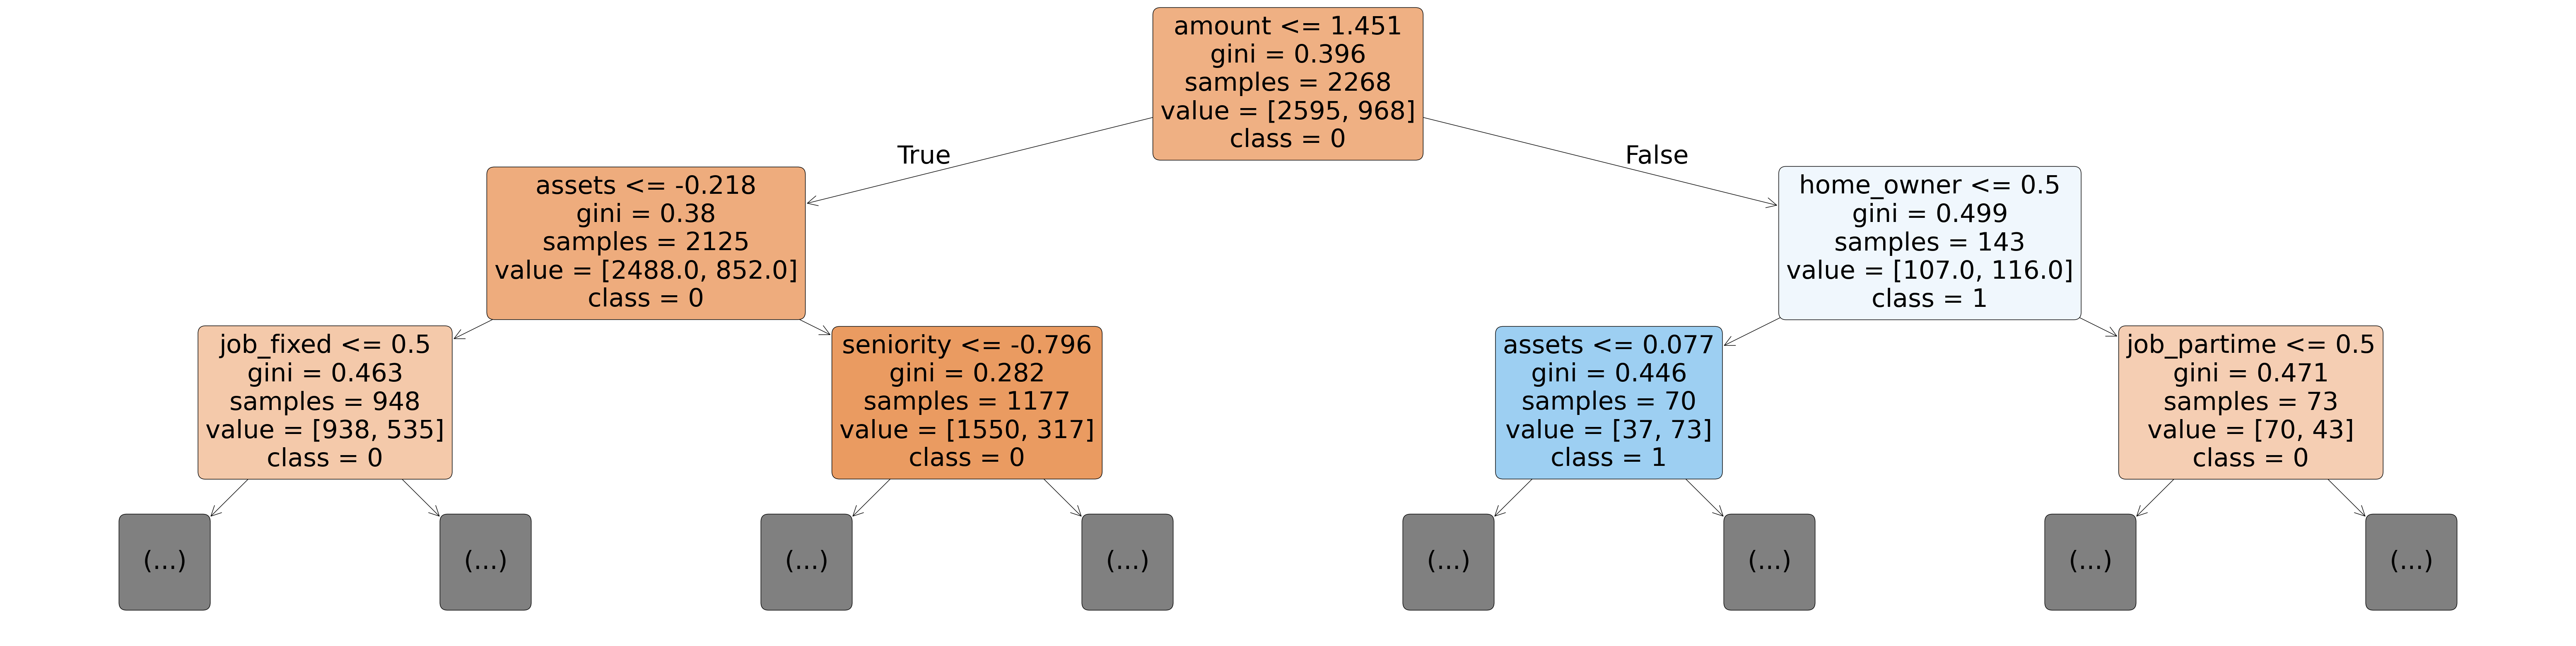

In [217]:
plt.figure(figsize=(80, 20))
plot_tree(model.estimators_[0], max_depth=2, feature_names=X_train.columns.tolist(), filled=True, rounded=True, class_names=model_classes_str);

In [219]:
len(model.estimators_)

100

Just like decision tree, random forests also assign an "importance" to each feature, by combining the importance values from individual trees.

In [222]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [224]:
importance_df.head(10)

,feature,importance
4,income,0.140659
0,seniority,0.110513
7,amount,0.108332
8,price,0.107102
2,age,0.091382
5,assets,0.070227
3,expenses,0.061160
1,time,0.045051
23,records_yes,0.038671
22,records_no,0.033857


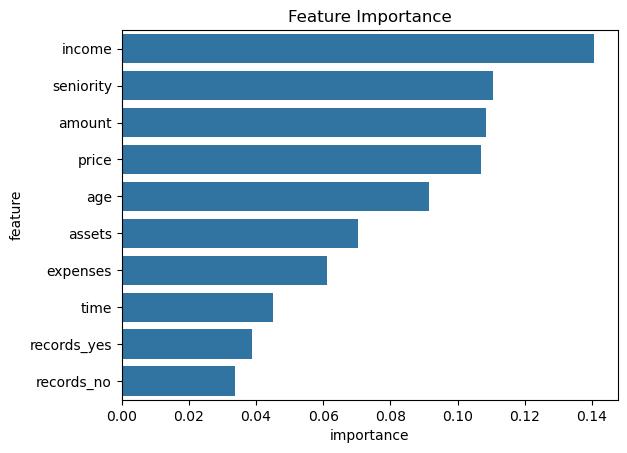

In [226]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature');

Notice that the distribution is a lot less skewed than that for a single decision tree.

## Hyperparameter Tuning with Random Forests

Just like decision trees, random forests also have several hyperparameters. In fact many of these hyperparameters are applied to the underlying decision trees. 

Let's study some the hyperparameters for random forests. You can learn more about them here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [ ]:
?RandomForestClassifier

Let's create a base model with which we can compare models with tuned hyperparameters.

In [231]:
base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
base_model.fit(X_train, train_target)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [233]:
base_train_acc = base_model.score(X_train, train_target)
base_test_acc = base_model.score(X_test, test_target)

In [235]:
base_accs = base_train_acc, base_test_acc
base_accs

(0.9997193376368229, 0.7755331088664422)

We can use this as a benchmark for hyperparmeter tuning.

### `n_estimators`

This argument controls the number of decision trees in the random forest. The default value is 100. For larger datasets, it helps to have a greater number of estimators. As a general rule, try to have as few estimators as needed. 


**10 estimators**

In [239]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=10)

In [241]:
model.fit(X_train, train_target)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)

In [245]:
model.score(X_train, train_target), model.score(X_test, test_target)

(0.982879595846197, 0.7654320987654321)

In [247]:
base_accs

(0.9997193376368229, 0.7755331088664422)

**500 estimators**

In [250]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=500)
model.fit(X_train, train_target)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

In [252]:
model.score(X_train, train_target)

0.9997193376368229

In [254]:
model.score(X_test, test_target)

0.7777777777777778

In [256]:
base_accs

(0.9997193376368229, 0.7755331088664422)

In [258]:
def test_params(**params):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(X_train, train_target)
    return model.score(X_train, train_target), model.score(X_test, test_target)

Let's test a few values of `max_depth` and `max_leaf_nodes`.

In [261]:
test_params(max_depth=5)

(0.8125175413976986, 0.7665544332210998)

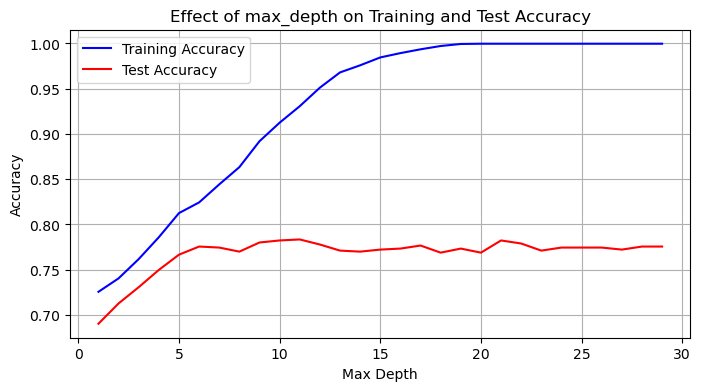

In [280]:
# Try different max_depth values
max_depths = range(1, 30)  # Try max_depth values from 1 to 30
train_scores = []
test_scores = []

for max_depth in max_depths:
    train_score, test_score = test_params(max_depth=max_depth)
    train_scores.append(train_score)
    test_scores.append(test_score)

# Plot the results
plt.figure(figsize=(8, 4))
plt.plot(max_depths, train_scores, label='Training Accuracy', color='blue')
plt.plot(max_depths, test_scores, label='Test Accuracy', color='red')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Effect of max_depth on Training and Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [282]:
# Find the best max_depth
best_max_depth = max_depths[np.argmax(test_scores)]
best_max_depth

11

In [263]:
test_params(max_depth=26)

(0.9997193376368229, 0.7744107744107744)

In [265]:
test_params(max_leaf_nodes=2**5)

(0.8170081392085321, 0.7699214365881033)

In [267]:
test_params(max_leaf_nodes=2**20)

(0.9997193376368229, 0.7744107744107744)

In [269]:
base_accs

(0.9997193376368229, 0.7755331088664422)

### `max_features`

Instead of picking all features (columns) for every split, we can specify that only a fraction of features be chosen randomly to figure out a split.

<img src="https://i.imgur.com/FXGWMDY.png" width="720">

Notice that the default value `auto` causes only $\sqrt{n}$ out of total features ( $n$ ) to be chosen randomly at each split. This is the reason each decision tree in the forest is different. While it may seem counterintuitive, choosing all features for every split of every tree will lead to identical trees, so the random forest will not generalize well. 

In [272]:
test_params(max_features='log2')

(0.9997193376368229, 0.7755331088664422)

In [274]:
test_params(max_features=3)

(0.9997193376368229, 0.7755331088664422)

In [276]:
test_params(max_features=6)

(0.9997193376368229, 0.7822671156004489)

### `min_samples_split` and `min_samples_leaf`

By default, the decision tree classifier tries to split every node that has 2 or more. You can increase the values of these arguments to change this behavior and reduce overfitting, especially for very large datasets.

In [285]:
test_params(min_samples_split=3, min_samples_leaf=2)

(0.9556553466180185, 0.7777777777777778)

test_params(min_samples_split=100, min_samples_leaf=60)

**EXERCISE**: Find the optimal values of `min_samples_split` and `min_samples_leaf`.

### `min_impurity_decrease`

This argument is used to control the threshold for splitting nodes. A node will be split if this split induces a decrease of the impurity (Gini index) greater than or equal to this value. It's default value is 0, and you can increase it to reduce overfitting.


In [293]:
test_params(min_impurity_decrease=1e-7)

(0.9997193376368229, 0.7800224466891134)

In [295]:
test_params(min_impurity_decrease=1e-2)

(0.7271961829918608, 0.691358024691358)

> **EXERCISE**: Find the optimal values of `min_impurity_decrease` for this dataset.

### `bootstrap`, `max_samples` 

By default, a random forest doesn't use the entire dataset for training each decision tree. Instead it applies a technique called bootstrapping. For each tree, rows from the dataset are picked one by one randomly, with replacement i.e. some rows may not show up at all, while some rows may show up multiple times.


<img src="https://i.imgur.com/W8UGaEA.png" width="640">

Bootstrapping helps the random forest generalize better, because each decision tree only sees a fraction of th training set, and some rows randomly get higher weightage than others.

In [299]:
test_params(bootstrap=False)

(0.9997193376368229, 0.7665544332210998)

In [301]:
base_accs

(0.9997193376368229, 0.7755331088664422)

When bootstrapping is enabled, you can also control the number or fraction of rows to be considered for each bootstrap using `max_samples`. This can further generalize the model.

<img src="https://i.imgur.com/rsdrL1W.png" width="640">

In [304]:
test_params(max_samples=0.9)

(0.9997193376368229, 0.7777777777777778)

### Putting it together

Let's train a random forest with customized hyperparameters based on our learnings. Of course, different hyperpraams

In [317]:
model = RandomForestClassifier(n_jobs=-1, 
                               random_state=42, 
                               n_estimators=500,
                               max_features=7,
                               max_depth=30
                               )

In [319]:
%%time
model.fit(X_train, train_target)

CPU times: total: 1.75 s
Wall time: 1.86 s


RandomForestClassifier(max_depth=30, max_features=7, n_estimators=500,
                       n_jobs=-1, random_state=42)

In [323]:
y_pred = model.predict(X_train)
auc = accuracy_score(train_target, y_pred)
print('train: ', auc)


y_pred = model.predict(X_test)
auc = accuracy_score(test_target, y_pred)
print('test: ', auc)

train:  0.9997193376368229
test:  0.7755331088664422
